## 데이터 주도 학습
- 학습의 방법들
    - 사람이 생각한 알고리즘
    - 사람이 생각한 특징 -> 기계학습
    - 신경망(딥러닝)
        - 위의 두개는 사람의 개입이 있지만 딥러닝은 중요한 특징까지 기계가 스스로 학습
        - 종단간 기계학습(end-to-end machine learning)이라고도 함
- 학습 시 주의할 점
    - overfitting

## 손실 함수
- 신경망 학습은 특정 지표를 가장 좋게 만들어주는 가중치 매개변수의 값을 탐색하는 것
    - 얼마나 잘 학습 됐는지를 보여주는 지표가 손실함수
    - 손실 함수는 신경망 성능의 '나쁨'을 나타내는 지표
        - 즉 클수록 나쁜 것을 의미함   
    - 주로 사용되는 손실 함수는 오차제곱합(sum of squares for error, SSE), 교차 엔트로피 오차(cross entropy error, CEE)
    

In [1]:
import numpy as np
import pandas as pd

#오차제곱합 구현
#MNIST 데이터 셋이라고 가정하고 실습 함
#아래는 0~9까지의 숫자일 확률을 softmax함수로 출력했다고 생각함
y1 = [0.1,0.05,0.6,0,0.05,0.1,0,0.1,0,0]
y2 = [0.1,0.05,0.1,0,0.05,0.1,0,0.6,0,0]
t = [0,0,1,0,0,0,0,0,0,0]

def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

print(sum_squares_error(np.array(y1), np.array(t)))
print(sum_squares_error(np.array(y2), np.array(t)))

0.09750000000000003
0.5975


In [2]:
#교차 엔트로피 오차
#이 값은 정답일 때의 출력이 전체 값을 정하게 됨
#오차제곱합은 모든 출력이 값을 결정하는데 이와는 다름

def cross_entropy_error(y,t):
    #0이 입력됐을 때 -inf로 만들지 않기 위한 조금의 보정
    delta = 1e-7
    return -np.sum(t * np.log(y+delta))

y1 = [0.1,0.05,0.6,0,0.05,0.1,0,0.1,0,0]
y2 = [0.1,0.05,0.1,0,0.05,0.1,0,0.6,0,0]
t = [0,0,1,0,0,0,0,0,0,0]

print(cross_entropy_error(np.array(y1), np.array(t)))
print(cross_entropy_error(np.array(y2), np.array(t)))

0.510825457099338
2.302584092994546


In [3]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [4]:
#모든 데이터를 다 평가하면 너무 크기 때문에 10개의 값만 배치로 가져옴
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t* np.log( y+ 1e-7 )) / batch_size

print(cross_entropy_error(np.array(y1), np.array(t)))
print(cross_entropy_error(np.array(y2), np.array(t)))

0.510825457099338
2.302584092994546


## 손실 함수를 사용하는 이유
- 어짜피 정확도를 구하는데 왜 손실 함수의 값이라는 우회적인 방법을 택하는가?
    - 신경망 학습에서는 최적의 매개변수를 탐색할 때 손실 함수의 값을 가능한 한 작게 하는 매개변수 값을 찾음
    - 가중치 매개변수의 값을 아주 조금 변화시킬 때 손실 함수가 어떻게 변하는지를 가지고 배개변수 값을 변화시킴
    - 정확도를 지표로 삼으면 미분값이 대부분의 장소에서 0이 되기 때문에 손실 함수를 사용함
        - 정확도를 지표로 삼으면 불연속 적으로 30 % -> 32% -> 38% 처럼 불연속 적으로 나타남
        - 계단 함수를 생각해보면 됨

0.1999999999990898


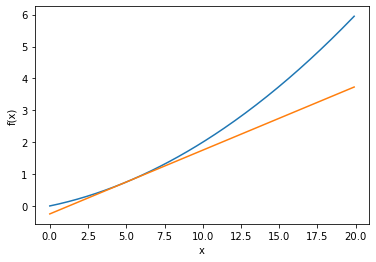

In [5]:
'''미분 구현
미분의 정의에 따라서 구현 했지만 아래의 함수는 개선점이 2가지 있음
1. 엄청 작은 값을 사용하고 싶어서 1e-50을 사용했지만 이는 반올림 오차 문제, 즉 올바로 표현할 수 없음 -> 1e-4 정도로 바꾸어야함
2. f의 차분과 관련된 것인데, 진정한 미분은 h를 무한히 0으로 좁히는 것인데 여기서 구현할 수 없기에 중심 차분 혹은 중앙차분으로 재구현 해야함
    우리가 기존에 보던 미분은 엄밀한 '해석적 미분' 이고 여기서 사용하는 미분은 '수치 미분'으로 근사치를 이용해서 미분값을 구하는 방식을 의미함
'''
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline


def numerical_diff(f,x):
    h = 1e-50
    return ((f(x+h) - f(x)))/h

def numerical_diff_new(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h))/(2*h)

def func1(x):
    return 0.01*x**2 + 0.1*x

# y-f(a) = f'(a)(x-a)
def tangent_line(f, x):
    d = numerical_diff_new(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

x = np.arange(0.0, 20.0, 0.1)
y = func1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(func1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()


In [8]:
'''
편미분 구현
'''

def func2(x):
    return x[0]**2 + x[1]**2
    #또는 return np.sum(x**2)

#x0 = 3, x1 = 4일 떄 x0에 대한 편미분 값은?
def function_tmp1(x0):
    return x0*x0 + 4.0+2.0

print(numerical_diff_new(function_tmp1, 3.00))

#x0=3, x1 = 4일 때, x1에 대한 편미분 값은?
def function_tmp2(x1):
    return 3*2 + x1*x1

print(numerical_diff_new(function_tmp2, 4.0))

6.000000000012662
7.999999999999119


In [26]:
'''
위에서는 각각의 편미분 값을 구했지만 여기서는 한번에 구할 수 있는 방법을 구현해본다. 
만약 입력을 정수형으로 주면 1e-4의 값이 무시 되어서 무조건 실수형으로 인풋을 주어야 한다. 
'''

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for i in range(x.size):
        tmp_val = x[i]
        x[i] = tmp_val + h
        fxh1 = f(x)
        
        x[i] = tmp_val-h
        fxh2 = f(x)
        
        grad[i] = (fxh1 - fxh2)/(2*h)
        
        x[i] = tmp_val
        
    return grad

numerical_gradient(func2, np.array([3.0,4.0]))

array([6., 8.])

In [36]:
def gradient_descent(f, init_x, lr = 0.01, step_num =100):
    x = init_x
    
    for i in range(step_num):
        grad =  numerical_gradient(f,x)
        x -= lr * grad
    return x

def function_2(x):
    return x[0] ** 2 + x[1] ** 2


# 아래의 결과를 통해서 학습률을 너무 크지도 너무 적지도 않게 정해야하는 이유를 알 수 있다. 
init_x = np.array([5.,5.])
print(gradient_descent(function_2, init_x,0.1, 1000))
init_x = np.array([5.,5.])
print(gradient_descent(function_2, init_x,1, 1000))
init_x = np.array([5.,5.])
print(gradient_descent(function_2, init_x,10, 1000))
init_x = np.array([5.,5.])
print(gradient_descent(function_2, init_x,100, 1000))

[5.47262693e-21 5.47262693e-21]
[4.99999996 4.99999996]
[-1.80220317e+12 -1.80220317e+12]
[-1.5650224e+12 -1.5650224e+12]


In [ ]:
'''
학습 알고리즘 구현하기
- 신경망 학습의 절차
    1. 미니배치
        - 훈련 데이터 중 일부를 무작위로 가져와서 그 미니 배치의 손실함수 값을 줄이기
    2. 기울기 산출
        - 미니배치의 손실 함수 값을 줄이기 위해서 각 가중치 매개변수의 기울기를 구함
    3. 매개변수 갱신
        - 가중치 매개변수를 기울기 방향으로 아주 조금 갱신
    4. 반복
'''

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std / np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std / np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def sigmoid(self, x):
        return 1/ (1+np.exp(-x))
    
    def softmax(self, x):
        c = np.max(x)
        exp_a = np.exp(x-c)
        sum_exp_a = np.sumn(exp_a)
        y = exp_a/sum_exp_a
        return y

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = self.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = self.softmax(a2)
        
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, aixs = 1)
        t = np.argmax(t, aixs = 1)
        
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x, t) 
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        